[INFO] loaded rows=91, files=5
[INFO] methods(raw): ['dr', 'gerryfair', 'multicalib', 'reduction', 'sequential']
[INFO] method=                      dr -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gamma
[INFO] method=              multicalib -> base= multicalib, ctrl=mc_lambda
[INFO] method=               reduction -> base=  reduction, ctrl=None
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_596891/1580459903.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_596891/1580459903.py:230: FutureWarning: The provided callable <function mean at 0x7f0594309700> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_596891/1580459903.py:230: FutureWarning: The provided callable <function mean at 0x7f0594309700> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/t

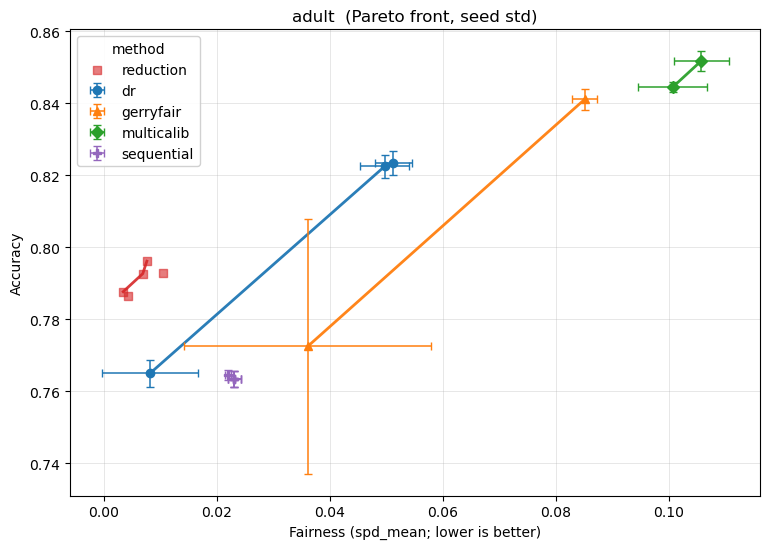

In [23]:
# %% -----------------------------------------------
# Accuracy–Fairness Tradeoff (Pareto) Plotter for ipynb
# - hardcoded config (no argparse)
# - method aliasing, control-parameter auto-detect
# - Pareto front + seed std errorbars
# --------------------------------------------------

import glob
import warnings
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

# ============== CONFIG ==============
DATASET = "adult"  # CSV 안의 dataset 값과 일치해야 함

# 분석할 CSV 파일 경로(글롭 패턴 가능). 필요에 맞게 수정하세요.
CSV_PATTERNS = [
    f"results_old/real/dr_{DATASET}/all_results.csv",          # 예: DR
    f"results_old/real/reduction_{DATASET}/all_results.csv", # 예: Reduction
    f"results_old/real/gerryfair_{DATASET}/all_results.csv", # 예: GerryFair
    f"results_old/real/mc_{DATASET}/all_results.csv",        # 예: Multicalibration
    f"results_old/real/seq_{DATASET}/all_results.csv",       # 예: Sequential
]

FAIRNESS_KEY = "spd_mean"     # x축 공정성 지표(낮을수록 좋음): spd_worst, spd_mean, supipm_w1, supipm_rbf 등
SEED_AGG = "mean"              # "mean" 또는 "median"
TITLE = DATASET                # 플롯 제목
SAVE_PATH = None               # None 또는 "tradeoff_adult.png"
XLIM = None                    # 예: (0.05, 0.25)
YLIM = None                    # 예: (0.78, 0.86)
ALPHA_POINTS = 0.6             # 산점도 투명도
DPI = 220                      # 저장 dpi

# 마커 지정(표준화된 메서드 이름 기준)
MARKERS = {"dr": "o", "reduction": "s", "gerryfair": "^", "multicalib": "D", "sequential": "P"}

# 메서드 이름 표준화(별칭)
METHOD_CANON = {
    "dr": "dr",
    "dr_subgroup_subset": "dr",
    "dr_subgroup_subset_3q": "dr",
    "gerry": "gerryfair",
    "gerryfair": "gerryfair",
    "mc": "multicalib",
    "multicalib": "multicalib",
    "seq": "sequential",
    "sequential": "sequential",
    "red": "reduction",
    "reduction": "reduction",
}

# 1순위 컨트롤 파라미터 후보(스윕 축)
CONTROL_COLS_PRIMARY = {
    "dr":          ["lambda_fair"],
    "reduction":   ["red_eps"],
    "gerryfair":   ["gamma"],
    "multicalib":  ["mc_alpha"],
    "sequential":  ["seq_alpha"],
}

# 대체 컨트롤 후보(1순위가 단일값이면 여기서 탐색)
CONTROL_COLS_FALLBACK = {
    "dr":          ["n_low", "n_low_frac", "shrink_smallest_frac"],
    "reduction":   ["red_constraint", "red_max_iter"],
    "gerryfair":   ["gf_max_iters", "gf_C"],
    "multicalib":  ["mc_lambda", "mc_max_iter"],
    "sequential":  ["seq_max_iter"],
}
# ====================================


# ---------- helpers ----------
def canon_method(m: str) -> str:
    if m is None:
        return "unknown"
    m = str(m)
    if m in METHOD_CANON:
        return METHOD_CANON[m]
    for k, v in METHOD_CANON.items():
        if m.startswith(k):
            return v
    return m

def pick_control_col(sub_df: pd.DataFrame, method_raw: str) -> Optional[str]:
    base = canon_method(method_raw)
    for c in CONTROL_COLS_PRIMARY.get(base, []):
        if c in sub_df.columns and sub_df[c].nunique(dropna=True) > 1:
            return c
    for c in CONTROL_COLS_FALLBACK.get(base, []):
        if c in sub_df.columns and sub_df[c].nunique(dropna=True) > 1:
            return c
    return None

def pareto_front_xy(x, y, eps=1e-9):
    """
    x 낮을수록(공정), y 높을수록(정확) 좋은 경우의 비지배 집합 index 반환.
    정렬(x asc, y desc) 후 누적 best y 유지.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    ok = np.isfinite(x) & np.isfinite(y)
    base_idx = np.arange(len(x))[ok]
    if base_idx.size == 0:
        return np.array([], dtype=int)

    order = np.lexsort((-y[ok], x[ok]))  # x asc, y desc
    xs = x[ok][order]
    ys = y[ok][order]
    idxs = base_idx[order]

    keep = []
    best_y = -np.inf
    for xi, yi, ii in zip(xs, ys, idxs):
        if yi >= best_y - eps:
            keep.append(ii)
            if yi > best_y:
                best_y = yi
    return np.array(sorted(keep, key=lambda i: x[i]), dtype=int)

def coerce_float_safe(v) -> float:
    try:
        return float(v)
    except Exception:
        return np.nan


# ---------- load ----------
file_list: List[str] = []
for pat in CSV_PATTERNS:
    file_list.extend(sorted(glob.glob(pat)))
if not file_list:
    raise FileNotFoundError("CSV_PATTERNS에 맞는 파일이 없습니다. 경로/패턴을 확인하세요.")

frames = []
for fp in file_list:
    try:
        df = pd.read_csv(fp)
        df["__source_file"] = fp
        frames.append(df)
    except Exception as e:
        print(f"[WARN] 읽기 실패: {fp} ({e})")

df_all = pd.concat(frames, ignore_index=True, sort=False)
print(f"[INFO] loaded rows={len(df_all)}, files={len(file_list)}")

# ---------- filter & derive ----------
if "dataset" not in df_all.columns:
    raise KeyError("CSV에 'dataset' 컬럼이 없습니다.")
df = df_all[df_all["dataset"] == DATASET].copy()
if df.empty:
    raise ValueError(f"dataset=='{DATASET}' 인 행이 없습니다.")

if FAIRNESS_KEY not in df.columns:
    raise KeyError(f"CSV에 '{FAIRNESS_KEY}' 컬럼이 없습니다.")
df["fairness_scalar"] = df[FAIRNESS_KEY].map(coerce_float_safe)

if "accuracy" not in df.columns:
    raise KeyError("CSV에 'accuracy' 컬럼이 없습니다.")
df["accuracy"] = df["accuracy"].map(coerce_float_safe)

df = df[np.isfinite(df["fairness_scalar"]) & np.isfinite(df["accuracy"])].copy()
if df.empty:
    raise ValueError("유효한 fairness_scalar/accuracy 값이 없습니다.")

if "method" not in df.columns:
    raise KeyError("CSV에 'method' 컬럼이 없습니다.")
methods = sorted(df["method"].dropna().unique().tolist())
print("[INFO] methods(raw):", methods)

agg_fun = np.mean if SEED_AGG == "mean" else np.median

# 색상(표준 메서드 단위로 고정)
base_methods = sorted(set(canon_method(m) for m in methods))
cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
COLOR_BY_BASE = {bm: cmap(i % cmap.N) for i, bm in enumerate(base_methods)}

# ---------- plot ----------
plt.figure(figsize=(7.8, 5.6))
method_label_used: Dict[str, bool] = {}

for m in methods:
    sub = df[df["method"] == m].copy()
    if sub.empty:
        continue

    base = canon_method(m)
    color = COLOR_BY_BASE.get(base, "C0")
    marker = MARKERS.get(base, "o")
    ctrl = pick_control_col(sub, m)
    print(f"[INFO] method={m:>24s} -> base={base:>11s}, ctrl={ctrl}")

    if ctrl is None:
        # 컨트롤 스윕 없음: 모든 점 산점도 + Pareto-front 선
        pts = sub[["fairness_scalar", "accuracy"]].dropna()
        if pts.empty:
            continue
        lbl = base if not method_label_used.get(base, False) else None
        plt.scatter(pts["fairness_scalar"], pts["accuracy"],
                    s=26, marker=marker, color=color, alpha=ALPHA_POINTS,
                    label=lbl, zorder=2)
        method_label_used[base] = True

        pf_idx = pareto_front_xy(pts["fairness_scalar"].values, pts["accuracy"].values, eps=1e-9)
        if pf_idx.size > 1:
            front = pts.iloc[pf_idx].sort_values("fairness_scalar", ascending=False)
            plt.plot(front["fairness_scalar"], front["accuracy"],
                     "-", color=color, linewidth=2.0, alpha=0.9, zorder=3)

    else:
        # (ctrl, seed)별 집계 → ctrl별 평균/표준편차
        needed = ["fairness_scalar", "accuracy", "seed", ctrl]
        missing = [c for c in needed if c not in sub.columns]
        if missing:
            print(f"[WARN] {m}: 누락 컬럼 {missing} → 산점도로 대체")
            pts = sub[["fairness_scalar", "accuracy"]].dropna()
            if pts.empty:
                continue
            lbl = base if not method_label_used.get(base, False) else None
            plt.scatter(pts["fairness_scalar"], pts["accuracy"],
                        s=26, marker=marker, color=color, alpha=ALPHA_POINTS,
                        label=lbl, zorder=2)
            method_label_used[base] = True
            continue

        grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
            fair=("fairness_scalar", agg_fun),
            acc=("accuracy",       agg_fun),
        ).reset_index().rename(columns={ctrl: "ctrl"})

        agg = grp.groupby("ctrl", dropna=False).agg(
            x=("fair", agg_fun),
            y=("acc",  agg_fun),
            x_std=("fair", "std"),
            y_std=("acc",  "std"),
            n=("fair", "count"),
        ).reset_index()

        if agg.empty:
            continue

        agg["x_std"] = agg["x_std"].fillna(0.0)
        agg["y_std"] = agg["y_std"].fillna(0.0)

        pf_idx = pareto_front_xy(agg["x"].values, agg["y"].values, eps=1e-9)
        best_acc_idx = agg["y"].idxmax()
        use_idx = sorted(set(pf_idx.tolist() + [best_acc_idx]), key=lambda i: agg.loc[i, "x"])
        front = agg.iloc[use_idx].copy().sort_values("x", ascending=False).reset_index(drop=True)

        lbl = base if not method_label_used.get(base, False) else None
        plt.errorbar(agg["x"], agg["y"],
                     xerr=agg["x_std"], yerr=agg["y_std"],
                     fmt=marker, color=color, ecolor=color,
                     elinewidth=1.1, capsize=3, linestyle="none",
                     label=lbl, zorder=3)
        method_label_used[base] = True

        if len(front) >= 2:
            plt.plot(front["x"], front["y"], "-", color=color, linewidth=2.0, alpha=0.95, zorder=2)

# ---------- cosmetics ----------
plt.xlabel(f"Fairness ({FAIRNESS_KEY}; lower is better)")
plt.ylabel("Accuracy")
plt.title(f"{TITLE}  (Pareto front, seed std)")

if XLIM: plt.xlim(XLIM)
if YLIM: plt.ylim(YLIM)

plt.grid(alpha=0.3, linewidth=0.7)
leg = plt.legend(title="method", frameon=True)
if leg:
    leg.get_frame().set_alpha(0.9)
plt.tight_layout()

if SAVE_PATH:
    plt.savefig(SAVE_PATH, dpi=DPI)
    print(f"[INFO] saved -> {SAVE_PATH}")
else:
    plt.show()
